# Scenario 3: MobileNetV2 with Keyframe Extraction

## Functions

In [1]:
# Import Required Libraries

# General Libraries
import os
import cv2
import time
import shutil
import itertools
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Katna Libraries
from Katna.video import Video
from Katna.writer import KeyFrameDiskWriter

# Data Preprocessing Libraries
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Adam Optimizer Libraries
from keras.optimizers.legacy import Adam # for Apple Silicon
# from keras.optimizers import Adam # for Windows

# MobileNetV2 Libraries
from keras.utils import plot_model
from keras.applications import MobileNetV2
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation Libraries
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Data Information Function
def data_information(dataframe, file_output_path, filename):
    file_type = dataframe.columns[1].split()[0]

    # Check if folder exists
    if not os.path.exists(file_output_path):
        os.makedirs(file_output_path)

    # Writing the data information to a text file
    with open(os.path.join(file_output_path, f"data_information_{filename}.txt"), 'w') as f:
        f.write("*"*50)
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write("DATA INFORMATION".center(50))
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write(f"Number of Labels : {dataframe['Label Type'].nunique()} Labels")
        f.write("\n")
        f.write(f"Number of {file_type}s : {len(dataframe)} {file_type}s")
        f.write("\n")
        f.write("*"*50)
        f.write("\n")
        for i in dataframe['Label Type'].value_counts().index:
            f.write(f"{i.ljust(20)} : {dataframe['Label Type'].value_counts()[i]} videos")
            f.write("\n")
        f.write("*"*50)
        f.write("\n")
        f.write("*"*50)
    
    # save dataframe to csv
    dataframe.to_csv(os.path.join(file_output_path, f"dataframe_{filename}.csv"), index=False)
    
    # showing the data information
    with open(os.path.join(file_output_path, f"data_information_{filename}.txt"), 'r') as f:
        print(f.read())

In [3]:
# Data Initialization Function
def data_initialization(dataset_path, file_output_path):
    # get the list of all the label types
    label_type = [item for item in os.listdir(dataset_path) if not item.startswith('.')]
    
    # get the list of all the videos
    activities = []
    for label in label_type:
        all_items = os.listdir(os.path.join(dataset_path, label))
        for item in all_items:
            if item.startswith('.'):
                continue
            else:
                videos = os.listdir(os.path.join(dataset_path, label, item))
            for video in videos:
                if video.endswith('.mp4'):      # can be changed to any other video format
                    activities.append((label, os.path.join(dataset_path, label, item, video)))
    
    # create a dataframe
    df = pd.DataFrame(activities, columns=['Label Type', 'Video Path'])

    # print data information
    data_information(dataframe=df, file_output_path=file_output_path, filename="data_initialization")

    return df

In [4]:
# Keyframe Extraction Function
def keyframe_extraction(dataframe, extracted_keyframes_output_folder, no_of_frames_to_returned):
  # start time
  start_time = time.time()

  # print initial message
  print(f"Extracting Keyframes from {len(dataframe)} videos...")
  
  # create a directory to save the keyframes
  os.makedirs(extracted_keyframes_output_folder, exist_ok=True)

  # For windows, the below if condition is must.
  if __name__ == "__main__":
    # initialize video module
    vd = Video()

    # number of images to be returned
    no_of_frames_to_returned = no_of_frames_to_returned # can be changed as per requirement

  # Extracting keyframe from all videos
  for i in tqdm(range(len(dataframe)), desc="Extracting Keyframes from Videos", colour='green'):
    # initialize diskwriter to save data at desired location
    diskwriter = KeyFrameDiskWriter(location=extracted_keyframes_output_folder + "/" + dataframe.iloc[i]['Label Type'])

    # Video file path
    video_file_path = dataframe.iloc[i]['Video Path']

    # extract keyframes and process data with diskwriter
    vd.extract_video_keyframes(
      no_of_frames=no_of_frames_to_returned, 
      file_path=video_file_path,
      writer=diskwriter
    )

  # end time
  end_time = time.time()
 
  # round the execution time to 2 decimal places
  exec_time = end_time - start_time
  exec_time = round(exec_time, 2)

  # print final message
  print("Keyframes extracted successfully!")
  print(f"Keyframes extracted from {len(dataframe)} videos and saved in {extracted_keyframes_output_folder}")
  print(f"Time taken to extract keyframes from {len(dataframe)} videos : {exec_time} seconds")

  return exec_time

In [5]:
# Data Initialization for Split Function
def data_initialization_split(dataset_path, file_output_path):
    # get the list of all the label types
    label_type = [item for item in os.listdir(dataset_path) if not item.startswith('.')]
    
    # get the list of all the videos
    activities = []
    for label in label_type:
        if label.startswith('.'):
            continue
        videos = os.listdir(os.path.join(dataset_path, label))
        for video in videos:
            if video.endswith('.jpeg'):     # can add or change the image format
                activities.append((label, os.path.join(dataset_path, label, video)))
    
    # create a dataframe
    df_extract = pd.DataFrame(activities, columns=['Label Type', 'Image Path'])

    data_information(dataframe=df_extract, file_output_path=file_output_path, filename="data_initialization_split")
    
    return df_extract

In [6]:
# Copy Files Function
def copy_files(train_dataframe, test_dataframe):
    # load variables
    dataframes = [train_dataframe, test_dataframe]
    destination_folder = 'SplittedFrames/extractedKeyframes' # change the destination folder according to the need

    for dataframe in dataframes:
        # set the destination folder
        if dataframe is train_dataframe:
            destination = os.path.join(destination_folder, 'train')
            current_dataframe = "Train"
        else:
            destination = os.path.join(destination_folder, 'test')
            current_dataframe = "Test"
        
        # Iterate over each row in the dataframe and copy the file to the destination folder
        for index, row in tqdm(
            dataframe.iterrows(), 
            total=len(dataframe), 
            desc=f"Copying splitted {current_dataframe} files          ", 
            unit="files", 
            position=0, 
            leave=True, 
            colour="green"):
            # Get the source and destination paths
            source_path = row['Image Path']
            destination_subfolder = row['Label Type']
            destination_path = os.path.join(destination, destination_subfolder, os.path.basename(source_path))

            # Create the destination subfolder if it doesn't exist
            os.makedirs(os.path.join(destination, destination_subfolder), exist_ok=True)

            # Copy the file to the destination folder
            shutil.copyfile(source_path, destination_path)

In [7]:
# Copy Files Function with Grayscaling
def copy_files_grayscaled(train_dataframe, test_dataframe):
    # load variables
    dataframes = [train_dataframe, test_dataframe]
    destination_folder = 'SplittedFrames/extractedKeyframes_grayscaled' # change the destination folder according to the need

    for dataframe in dataframes:
        # set the destination folder
        if dataframe is train_dataframe:
            destination = os.path.join(destination_folder, 'train')
            current_dataframe = "Train"
        else:
            destination = os.path.join(destination_folder, 'test')
            current_dataframe = "Test"
        
        # Iterate over each row in the dataframe and copy the file to the destination folder
        for index, row in tqdm(
            dataframe.iterrows(), 
            total=len(dataframe), 
            desc=f"Copying splitted grayscale {current_dataframe} files ", 
            unit="files", 
            position=0, 
            leave=True, 
            colour="green"):
            # Get the source and destination paths
            source_path = row['Image Path']
            destination_subfolder = row['Label Type']
            destination_path = os.path.join(destination, destination_subfolder, os.path.basename(source_path))

            # Create the destination subfolder if it doesn't exist
            os.makedirs(os.path.join(destination, destination_subfolder), exist_ok=True)

            # Read the image
            image = cv2.imread(source_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image to the destination folder
            cv2.imwrite(destination_path, gray_image)

In [8]:
# Split Data Function
def split_data(dataframe, test_size, file_output_path):
    # print initial message
    print("Splitting the data into train and test...")

    # Split the data into train and test
    df_train, df_test = train_test_split(dataframe, test_size=test_size, random_state=42)

    # save the dataframes to csv
    df_train.to_csv(os.path.join(file_output_path, "dataframe_dataset_train.csv"), index=False)
    df_test.to_csv(os.path.join(file_output_path, "dataframe_dataset_test.csv"), index=False)

    # # copy files to the destination folder
    # copy_files(train_dataframe=df_train, test_dataframe=df_test)
    # copy_files_grayscaled(train_dataframe=df_train, test_dataframe=df_test)

    # print final message
    print("Data split successfully into train and test!")

    # print data information
    print("\n")
    print(f"Total image in train set    : {len(df_train)} images")
    print(f"Total image in test set     : {len(df_test)} images")

    return df_train, df_test

In [9]:
# Data Augmentation Function
def data_augmentation(img_width, img_height, batch_size):
    # Splitted data directories
    train_dir = 'SplittedFrames/extractedKeyframes_grayscaled/train'
    test_dir = 'SplittedFrames/extractedKeyframes_grayscaled/test'

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True
    )

    # Data normalization for testing
    test_datagen = ImageDataGenerator(
        # rescale=1.0/255,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True
    )

    # Load training data
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', 
        shuffle=True
    )

    # Load validation data
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', 
        shuffle=False
    )

    # Load testing data
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator


In [10]:
# MobileNetV2 Model
def mobileNetV2_model(learning_rate, train_generator, file_output_path):
    # Variable
    num_classes = train_generator.num_classes

    # Create the MobileNetV2 model
    model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers in the base model
    for layer in model.layers[:-1]:
        layer.trainable = False

    # Add classification layer to the model
    model = tensorflow.keras.Sequential([
        model,
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax', name='predictions')
    ])

    model = Model(inputs=model.input, outputs=model.output, name='MobileNetV2')

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    # callbacks
    folder_name = file_output_path
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    model_checkpoint_filename = 'Scenario3_mobilenetv2_checkpoint_epoch_{epoch:02d}_val_loss_{val_loss:.2f}_val_accuracy_{val_accuracy:.2f}_loss_{loss:.2f}_accuracy_{accuracy:.2f}.h5'
    model_checkpoint = ModelCheckpoint(os.path.join(folder_name, model_checkpoint_filename), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    early_stopping = EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)
    
    return model, model_checkpoint, early_stopping

In [11]:
# Time Conversion Function
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
 
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [12]:
# Grid Search Print
def gs_print(accuracy, learning_rate, model, execution_time, file_output_path):
    # save cell output to a text file
    with open(os.path.join(file_output_path, "grid_search_output.txt"), "w") as f:
        print("*"*65, file=f)
        print("*"*65, file=f)
        print("GRID SEARCH RESULTS".center(65), file=f)
        print("*"*65, file=f)
        print(f"Best Learning Rate              : {learning_rate}", file=f)
        print(f"Best Accuracy                   : {accuracy}", file=f)
        print(f"Best Execution Time (seconds)   : {execution_time}", file=f)
        execution_time = convert(execution_time)
        print(f"Best Execution Time (hh:mm:ss)  : {execution_time}", file=f)
        print("*"*65, file=f)
        print("Summary of the Best Model".center(65), file=f)
        model.summary(print_fn=lambda x: f.write(x + '\n'))
        print("*"*65, file=f)
    
    with open(os.path.join(file_output_path, "grid_search_output.txt"), "r") as f:
        print(f.read())

    # Save model plot
    plot_model(model, to_file=os.path.join(file_output_path, "model_plot.png"), show_shapes=True, show_layer_names=True)

In [13]:
# Grid Search Function
def grid_search(learning_rate, epochs, train_generator, val_generator, file_output_path):
    
    # all variables
    best_accuracy = 0
    best_val_accuracy = 0
    best_learning_rate = 0
    best_execution_time = 0
    best_model = None

    # Grid Search
    for lr in learning_rate:
        print(f"Learning Rate: {lr}")
        model, model_checkpoint, early_stopping = mobileNetV2_model(learning_rate=lr, train_generator=train_generator, file_output_path=file_output_path)

        start_time = time.time()
        history = model.fit(train_generator, validation_data=val_generator, steps_per_epoch=len(train_generator), validation_steps=len(val_generator), epochs=epochs, callbacks=[model_checkpoint, early_stopping], verbose=1)
        end_time = time.time()
        exec_time = end_time - start_time
        exec_time = round(exec_time, 2)
        print(f"Time taken to train the {lr} model : {exec_time} seconds")

        # Save history to a file
        history_df = pd.DataFrame(history.history)
        history_df.to_csv(os.path.join(file_output_path, 'history.csv'), index=False)

        accuracy = history.history['accuracy'][-1]
        val_accuracy = history.history['val_accuracy'][-1]
        if val_accuracy > best_val_accuracy:
            best_accuracy = accuracy
            best_val_accuracy = val_accuracy
            best_learning_rate = lr
            best_model = model
            best_execution_time = exec_time

    # Save the best_model
    best_model.save(os.path.join(file_output_path, 'best_model.h5'))

    return best_accuracy, best_learning_rate, best_model, best_execution_time

In [14]:
# Save the Model Plot Function
def save_plot_model(file_output_path):
    # history
    history = pd.read_csv(os.path.join(file_output_path, 'history.csv'))

    # plot the accuracy and loss of the model side by side
    plt.figure(figsize=(12, 6))

    # plot the accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # plot the loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # save the plot
    plt.savefig(os.path.join(file_output_path, 'model_accuracy_loss.png'))
    plt.show()

In [15]:
# Evaluate Model Function
def evaluate_model(test_generator, file_output_path):
    # load the best model
    model = load_model(os.path.join(file_output_path, 'best_model.h5'))

    # evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator), verbose=1)

    # save the evaluation results csv
    evaluation_results = pd.DataFrame({'Test Loss': [test_loss], 'Test Accuracy': [test_accuracy]})
    evaluation_results.to_csv(os.path.join(file_output_path, 'model_evaluation_results.csv'), index=False)

    # show the evaluation results csv
    print("\n")
    print("*"*75)
    print(tabulate(evaluation_results, headers='keys', tablefmt='pretty'))
    print(f"Model evaluation results saved in {file_output_path} as model_evaluation_results.csv")

In [16]:
# Predict Model Function
def predict_model(test_generator, file_output_path):
    """
    Predicts the classes for the given test data using a trained model and saves the predictions, evaluation results,
    confusion matrix, and classification report to CSV files.

    Args:
        test_generator (object): The test data generator.
        file_output_path (str): The path to save the output files.

    Returns:
        None
    """
    # model predictions
    # load the model
    model = load_model(os.path.join(file_output_path, 'best_model.h5'))
    test_dir = 'SplittedFrames/extractedKeyframes_grayscaled/test'

    actual_classes = []
    predicted_classes = []
    predicted_probabilities = []



    # Get the total number of files
    total_files = sum(len(files) for _, _, files in os.walk('SplittedFrames/extractedKeyframes_grayscaled/test'))

    # Create a progress bar
    progress_bar = tqdm(total=total_files, desc='Loading')

    for folder in os.listdir(test_dir):
        if folder.startswith('.'):
            continue
        for file in os.listdir(os.path.join(test_dir, folder)):
            if file.startswith('.'):
                continue
            actual_classes.append(test_generator.class_indices[folder])

            img = cv2.imread(os.path.join(test_dir, folder, file))
            img = cv2.resize(img, (224, 224))
            img_normalized = img / 255.0
            img_array = np.array([img_normalized])

            pred = model.predict(img_array, verbose=0)
            predicted_probabilities.append(np.array(pred))
            predictions = np.argmax(pred)
            predicted_classes.append(predictions)
            
            # Update the progress bar
            progress_bar.update(1)
    
    # Close the progress bar
    progress_bar.close()

    # get the class labels
    class_labels = list(test_generator.class_indices.keys())


    
    # model predictions evaluation
    # confusion matrix
    cm = confusion_matrix(actual_classes, predicted_classes)

    # classification report
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels)
    
    # accuracy
    accuracy = accuracy_score(actual_classes, predicted_classes)

    # precision
    precision = precision_score(actual_classes, predicted_classes, average='weighted')

    # recall
    recall = recall_score(actual_classes, predicted_classes, average='weighted')

    # f1-score
    f1 = f1_score(actual_classes, predicted_classes, average='weighted')


    
    # print the confusion matrix and classification report
    print("\n")
    print("*"*75)
    print("Confusion Matrix".center(75))
    print(cm)
    print("*"*75)
    print("Classification Report".center(75))
    print(cr)
    print("*"*75)
    
    # plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(os.path.join(file_output_path, 'confusion_matrix.png'))

    
    # save the evaluation results
    print("\n")
    print("*"*75) 
    # save the model predictions to a csv
    predicted_probabilities = np.array(predicted_probabilities)
    predicted_probabilities = np.squeeze(predicted_probabilities, axis=1)
    predictions_df = pd.DataFrame(predicted_probabilities, columns=class_labels)
    predictions_df['Actual Class'] = actual_classes
    predictions_df['Predicted Class'] = predicted_classes
    predictions_df.to_csv(os.path.join(file_output_path, 'model_predictions.csv'), index=False)
    print(f"Model predictions saved in {file_output_path} as model_predictions.csv")

    # save the predictions evaluation results to a csv
    predictions_evaluation_results = pd.DataFrame({'Accuracy': [accuracy], 'Precision': [precision], 'Recall': [recall], 'F1-Score': [f1]})
    predictions_evaluation_results.to_csv(os.path.join(file_output_path, 'model_predictions_evaluation_results.csv'), index=False)
    print(f"Model predictions evaluation results saved in {file_output_path} as model_predictions_evaluation_results.csv")
    
    # save the confusion matrix to a csv
    cm_df = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    cm_df.to_csv(os.path.join(file_output_path, 'confusion_matrix.csv'))
    print("Confusion matrix saved in {file_output_path} as confusion_matrix.csv")

    # save the classification report to a csv
    cr = classification_report(actual_classes, predicted_classes, target_names=class_labels, output_dict=True)
    cr_df = pd.DataFrame(cr).transpose()
    cr_df.to_csv(os.path.join(file_output_path, 'classification_report.csv'))
    print("Classification report saved in {file_output_path} as classification_report.csv")

In [17]:
# Prioritizing memory GPU for processing (IMPORTANT)
print(" Prioritizing memory GPU for processing ".upper().center(75, "*"))

gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  print("GPU is available")
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("*"*75)

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

# tensorflow.debugging.set_log_device_placement(True)  # log device placement

print("*"*75)

# Place tensors on the CPU
with tensorflow.device('/GPU:0'):
  a = tensorflow.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tensorflow.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tensorflow.matmul(a, b)
print(c)

print("*"*75)

# change processing to GPU
print(tensorflow.config.list_physical_devices('GPU'))

print("*"*75)

# select GPU
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tensorflow.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tensorflow.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

****************** PRIORITIZING MEMORY GPU FOR PROCESSING *****************
GPU is available
1 Physical GPUs, 1 Logical GPUs
***************************************************************************
Num GPUs Available:  1
***************************************************************************


2024-06-04 21:08:27.491157: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-06-04 21:08:27.491188: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-06-04 21:08:27.491202: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-06-04 21:08:27.491440: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-04 21:08:27.491657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
***************************************************************************
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
***************************************************************************
1 Physical GPUs, 1 Logical GPU


## Main Codes

In [18]:
# Set Variables
dataset_path = 'Dataset/UCF11_updated_mpg/'
extracted_keyframes = 'Frames/extractedKeyframes/'
file_output_path = 'Model/Scenario3/'  # try to change pooling from GAP to GMP

In [19]:
# Data initialization
df_dataset = data_initialization(dataset_path=dataset_path, file_output_path=file_output_path)

**************************************************
**************************************************
                 DATA INFORMATION                 
**************************************************
Number of Labels : 11 Labels
Number of Videos : 1600 Videos
**************************************************
horse_riding         : 198 videos
tennis_swing         : 167 videos
soccer_juggling      : 156 videos
diving               : 156 videos
biking               : 145 videos
golf_swing           : 142 videos
basketball           : 141 videos
swing                : 137 videos
walking              : 123 videos
trampoline_jumping   : 119 videos
volleyball_spiking   : 116 videos
**************************************************
**************************************************


In [20]:
# Show the dataset dataframe
df_dataset = pd.read_csv(os.path.join(file_output_path, 'dataframe_data_initialization.csv'))
print(df_dataset)

              Label Type                                         Video Path
0     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
1     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
2     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
3     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
4     volleyball_spiking  Dataset/UCF11_updated_mpg/volleyball_spiking/v...
...                  ...                                                ...
1595              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1596              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1597              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1598              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...
1599              diving  Dataset/UCF11_updated_mpg/diving/v_diving_08/v...

[1600 rows x 2 columns]


In [ ]:
# # Skip Keyframe Extraction if already done
# # Keyframe extraction
# number_of_keyframes = 100
# keyframe_extraction_execution_time = keyframe_extraction(dataframe=df_dataset, 
#                                                          extracted_keyframes_output_folder=extracted_keyframes,
#                                                          no_of_frames_to_returned=number_of_keyframes)

In [ ]:
# # Skip Keyframe Extraction if already done
# # Print the keyframe extraction execution time
# with open(os.path.join(file_output_path, 'keyframe_extraction_execution_time.txt'), 'w') as f:
#     f.write(str(keyframe_extraction_execution_time))

In [21]:
# Data initialization for splitting the dataset
df_dataset_extracted  = data_initialization_split(dataset_path=extracted_keyframes, file_output_path=file_output_path)

**************************************************
**************************************************
                 DATA INFORMATION                 
**************************************************
Number of Labels : 11 Labels
Number of Images : 14548 Images
**************************************************
soccer_juggling      : 2400 videos
horse_riding         : 1833 videos
biking               : 1534 videos
walking              : 1384 videos
tennis_swing         : 1268 videos
diving               : 1262 videos
golf_swing           : 1194 videos
trampoline_jumping   : 1102 videos
swing                : 1069 videos
basketball           : 951 videos
volleyball_spiking   : 551 videos
**************************************************
**************************************************


In [22]:
# show dataframe from csv
df_datasplit = pd.read_csv(os.path.join(file_output_path, 'dataframe_data_initialization_split.csv'))
print(df_datasplit)

               Label Type                                         Image Path
0      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
1      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
2      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
3      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
4      volleyball_spiking  Frames/extractedKeyframes/volleyball_spiking/v...
...                   ...                                                ...
14543              diving  Frames/extractedKeyframes/diving/v_diving_16_0...
14544              diving  Frames/extractedKeyframes/diving/v_diving_03_0...
14545              diving  Frames/extractedKeyframes/diving/v_diving_06_0...
14546              diving  Frames/extractedKeyframes/diving/v_diving_15_0...
14547              diving  Frames/extractedKeyframes/diving/v_diving_01_0...

[14548 rows x 2 columns]


In [ ]:
# # Skip splitting data if already done
# # Split data

# # variable
# test_size = 0.2

# # Split data into train and test
# df_train, df_test = split_data(dataframe=df_datasplit, test_size=test_size, file_output_path=file_output_path)

In [23]:
# Data Augmentation

# Image size
img_width, img_height = 224, 224

# Batch size
batch_size = 32

# Load data
train_generator, val_generator, test_generator = data_augmentation(img_width, img_height, batch_size)

Found 9316 images belonging to 11 classes.
Found 2322 images belonging to 11 classes.
Found 2910 images belonging to 11 classes.


In [24]:
# call the grid search function
learning_rate = [0.0001]
epochs = 100

best_accuracy, best_learning_rate, best_model, best_execution_time = grid_search(learning_rate, epochs, train_generator, val_generator, file_output_path)

Learning Rate: 0.0001
Epoch 1/100


2024-05-02 21:05:57.501978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


292/292 [==============================] - ETA: 0s - loss: 1.8637 - accuracy: 0.3770

2024-05-02 21:06:47.673254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.44875, saving model to Model/Scenario3/Scenario3_mobilenetv2_checkpoint_epoch_01_val_loss_1.60_val_accuracy_0.45_loss_1.86_accuracy_0.38.h5


/Users/rikza/tensorflow-test/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


292/292 [==============================] - 64s 215ms/step - loss: 1.8637 - accuracy: 0.3770 - val_loss: 1.5963 - val_accuracy: 0.4488
Epoch 2/100
292/292 [==============================] - ETA: 0s - loss: 1.1308 - accuracy: 0.6560
Epoch 2: val_accuracy improved from 0.44875 to 0.54953, saving model to Model/Scenario3/Scenario3_mobilenetv2_checkpoint_epoch_02_val_loss_1.28_val_accuracy_0.55_loss_1.13_accuracy_0.66.h5
292/292 [==============================] - 68s 233ms/step - loss: 1.1308 - accuracy: 0.6560 - val_loss: 1.2828 - val_accuracy: 0.5495
Epoch 3/100
292/292 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.7555
Epoch 3: val_accuracy improved from 0.54953 to 0.60078, saving model to Model/Scenario3/Scenario3_mobilenetv2_checkpoint_epoch_03_val_loss_1.16_val_accuracy_0.60_loss_0.85_accuracy_0.76.h5
292/292 [==============================] - 74s 255ms/step - loss: 0.8468 - accuracy: 0.7555 - val_loss: 1.1618 - val_accuracy: 0.6008
Epoch 4/100
292/292 [=====

In [25]:
# print grid search results
gs_print(accuracy=best_accuracy, learning_rate=best_learning_rate, model=best_model, execution_time=best_execution_time, file_output_path=file_output_path)

*****************************************************************
*****************************************************************
                       GRID SEARCH RESULTS                       
*****************************************************************
Best Learning Rate              : 0.0001
Best Accuracy                   : 0.9535208344459534
Best Execution Time (seconds)   : 0:40:25
Best Execution Time (hh:mm:ss)  : 0:40:25
*****************************************************************
                    Summary of the Best Model                    
Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224_input  [(None, 224, 224, 3)]     0         
  (InputLayer)                                                   
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional) 

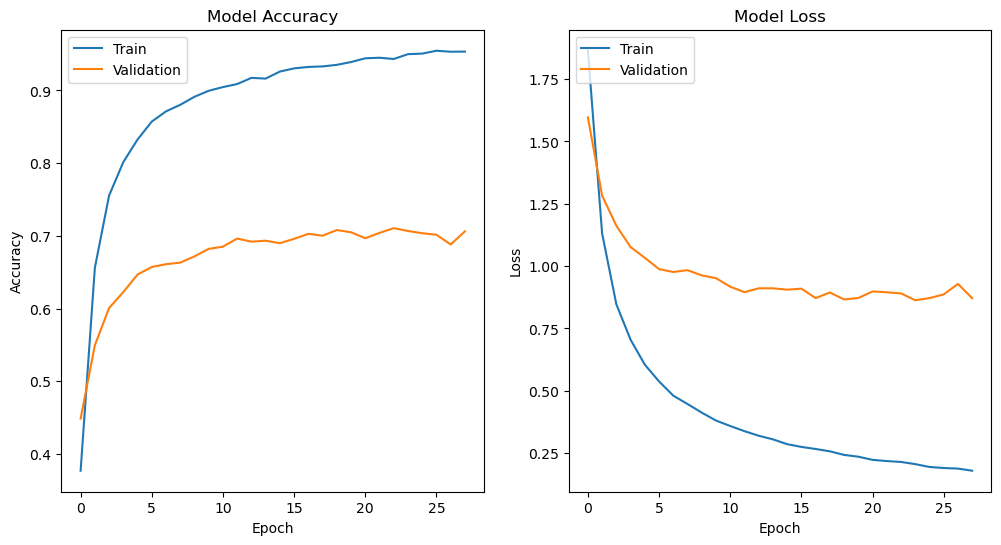

In [26]:
# Save the Model Plot
save_plot_model(file_output_path=file_output_path)

In [27]:
# Evaluate the Model
evaluate_model(test_generator=test_generator, file_output_path=file_output_path)

2024-05-02 21:46:24.302872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


91/91 [==============================] - 15s 161ms/step - loss: 3.0858 - accuracy: 0.1605


***************************************************************************
+---+-------------------+---------------------+
|   |     Test Loss     |    Test Accuracy    |
+---+-------------------+---------------------+
| 0 | 3.085763931274414 | 0.16048109531402588 |
+---+-------------------+---------------------+
Model evaluation results saved in Model/Scenario3/ as model_evaluation_results.csv


Loading: 100%|█████████▉| 2910/2911 [01:47<00:00, 27.07it/s]




***************************************************************************
                              Confusion Matrix                             
[[151   0   2   3   1   6   0  18   1   2   3]
 [  1 269   2   3   4  10   0   0   3   0  14]
 [  0   0 252   0   0   0   0   0   0   0   1]
 [  3   1   0 230   0  10   0   1   1   0   0]
 [  0   1   0   0 340   5   0   0   1   1   6]
 [  0   3   0  33   1 410   1   9   0   0  11]
 [  0   1   1   2   1   5 182   0   6   0   9]
 [ 14   0   0   4   0   3   2 227   3   0   0]
 [  2   6   1   4   1   4   6   1 201   0   2]
 [  4   2   1   1   1   5   0   1   0 105   0]
 [  1   9   1  13   4  19   7   0   3   0 231]]
***************************************************************************
                           Classification Report                           
                    precision    recall  f1-score   support

        basketball       0.86      0.81      0.83       187
            biking       0.92      0.88      0.90      

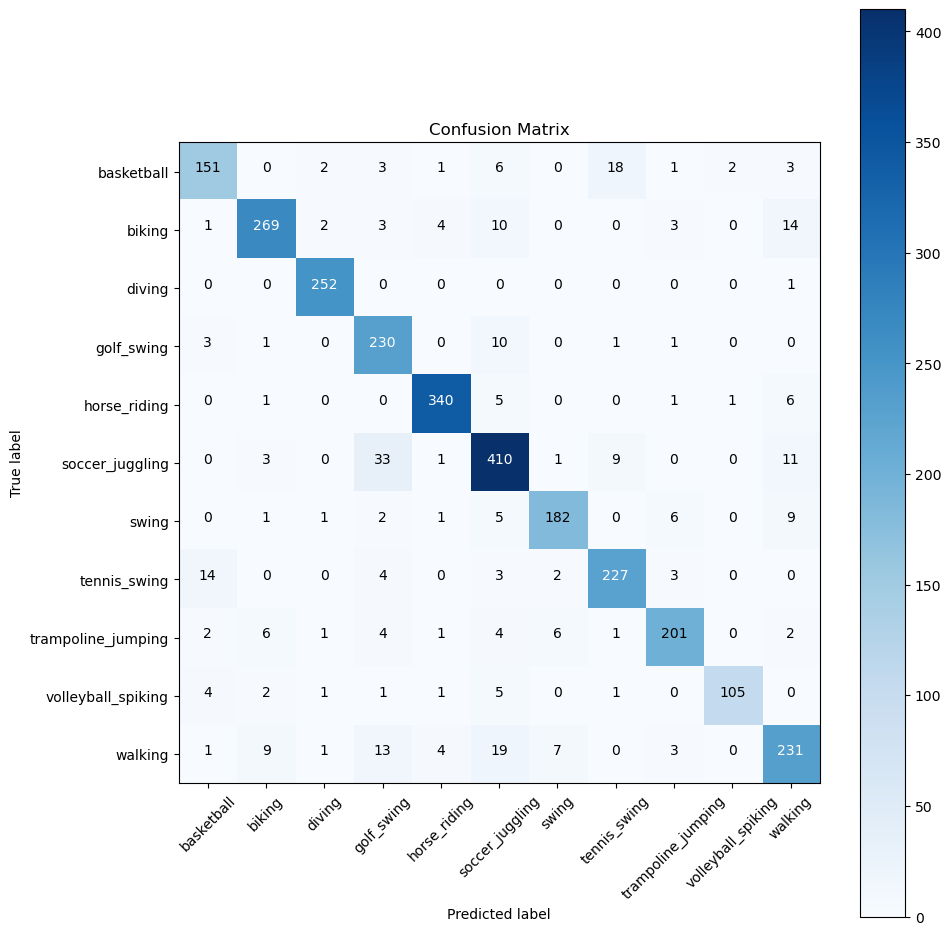

In [28]:
# Predict the Model
predict_model(test_generator=test_generator, file_output_path=file_output_path)

## Manual Evaluation

In [24]:
# model predictions
# load the model
model = load_model(os.path.join(file_output_path, 'best_model.h5'))
test_dir = 'SplittedFrames/extractedKeyframes_grayscaled/test'

actual_classes = []
predicted_classes = []
predicted_probabilities = []


# Get the total number of files
total_files = sum(len(files) for _, _, files in os.walk('SplittedFrames/extractedKeyframes_grayscaled/test'))

# Create a progress bar
progress_bar = tqdm(total=total_files, desc='Loading')

for folder in os.listdir(test_dir):
    if folder.startswith('.'):
        continue
    for file in os.listdir(os.path.join(test_dir, folder)):
        if file.startswith('.'):
            continue
        actual_classes.append(test_generator.class_indices[folder])

        img = cv2.imread(os.path.join(test_dir, folder, file))
        img = cv2.resize(img, (224, 224))
        img_normalized = img / 255.0
        img_array = np.array([img_normalized])

        pred = model.predict(img_array, verbose=0)
        predicted_probabilities.append(np.array(pred))
        predictions = np.argmax(pred)
        predicted_classes.append(predictions)
        
        # Update the progress bar
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()

# get the class labels
class_labels = list(test_generator.class_indices.keys())

# model predictions evaluation
# calculate  TP, TN, FP, FN
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(actual_classes)):
    if actual_classes[i] == predicted_classes[i]:
        if actual_classes[i] == 1:
            TP += 1
        else:
            TN += 1
    else:
        if actual_classes[i] == 1:
            FN += 1
        else:
            FP += 1

# calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy}")

# calculate precision
precision = TP / (TP + FP)
print(f"Precision: {precision}")

# calculate recall
recall = TP / (TP + FN)
print(f"Recall: {recall}")

# calculate f1-score
f1 = (2 * precision * recall) / (precision + recall)
print(f"F1-Score: {f1}")


Loading: 100%|█████████▉| 2910/2911 [02:05<00:00, 23.26it/s]

Accuracy: 0.8927835051546392
Precision: 0.4944852941176471
Recall: 0.8790849673202614
F1-Score: 0.6329411764705881


In [25]:
from sklearn.metrics import confusion_matrix
y_true = actual_classes
y_pred = predicted_classes
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[151   0   2   3   1   6   0  18   1   2   3]
 [  1 269   2   3   4  10   0   0   3   0  14]
 [  0   0 252   0   0   0   0   0   0   0   1]
 [  3   1   0 230   0  10   0   1   1   0   0]
 [  0   1   0   0 340   5   0   0   1   1   6]
 [  0   3   0  33   1 410   1   9   0   0  11]
 [  0   1   1   2   1   5 182   0   6   0   9]
 [ 14   0   0   4   0   3   2 227   3   0   0]
 [  2   6   1   4   1   4   6   1 201   0   2]
 [  4   2   1   1   1   5   0   1   0 105   0]
 [  1   9   1  13   4  19   7   0   3   0 231]]


In [26]:
num_classes = len(cm)  # Assuming a square matrix
class_wise_metrics = {}

for class_index in range(num_classes):
  # Extract elements from the confusion matrix
  tp = cm[class_index, class_index]  # True Positives (diagonal cell)
  fp_values = cm[:, class_index]  # All values in the row (excluding diagonal)
  fn_values = cm[class_index]  # All values in the column (excluding diagonal)

  # Calculate FP (excluding diagonal cell)
  fp = np.sum(fp_values) - tp

  # Calculate FN (excluding diagonal cell)
  fn = np.sum(fn_values) - tp

  # Store results for this class
  class_wise_metrics[class_index] = {
      "tp": tp,
      "fp": fp,
      "fn": fn
  }
print(class_wise_metrics)

{0: {'tp': 151, 'fp': 25, 'fn': 36}, 1: {'tp': 269, 'fp': 23, 'fn': 37}, 2: {'tp': 252, 'fp': 8, 'fn': 1}, 3: {'tp': 230, 'fp': 63, 'fn': 16}, 4: {'tp': 340, 'fp': 13, 'fn': 14}, 5: {'tp': 410, 'fp': 67, 'fn': 58}, 6: {'tp': 182, 'fp': 16, 'fn': 25}, 7: {'tp': 227, 'fp': 30, 'fn': 26}, 8: {'tp': 201, 'fp': 18, 'fn': 27}, 9: {'tp': 105, 'fp': 3, 'fn': 15}, 10: {'tp': 231, 'fp': 46, 'fn': 57}}


In [27]:
total_data_points = len(y_true)  # Assuming y_true has all data points

for class_index in range(num_classes):
  # Get metrics from previous step
  tp = class_wise_metrics[class_index]["tp"]
  fp = class_wise_metrics[class_index]["fp"]
  fn = class_wise_metrics[class_index]["fn"]

  # Calculate TN (all other classes classified correctly)
  tn = total_data_points - (tp + fp + fn)

  # Update dictionary with TN
  class_wise_metrics[class_index]["tn"] = tn

print(class_wise_metrics)


{0: {'tp': 151, 'fp': 25, 'fn': 36, 'tn': 2698}, 1: {'tp': 269, 'fp': 23, 'fn': 37, 'tn': 2581}, 2: {'tp': 252, 'fp': 8, 'fn': 1, 'tn': 2649}, 3: {'tp': 230, 'fp': 63, 'fn': 16, 'tn': 2601}, 4: {'tp': 340, 'fp': 13, 'fn': 14, 'tn': 2543}, 5: {'tp': 410, 'fp': 67, 'fn': 58, 'tn': 2375}, 6: {'tp': 182, 'fp': 16, 'fn': 25, 'tn': 2687}, 7: {'tp': 227, 'fp': 30, 'fn': 26, 'tn': 2627}, 8: {'tp': 201, 'fp': 18, 'fn': 27, 'tn': 2664}, 9: {'tp': 105, 'fp': 3, 'fn': 15, 'tn': 2787}, 10: {'tp': 231, 'fp': 46, 'fn': 57, 'tn': 2576}}


In [28]:
# calculate accuracy, recall, precision, and F1-score for each class
class_metrics = {}

for class_index in range(num_classes):
    tp = class_wise_metrics[class_index]["tp"]
    fp = class_wise_metrics[class_index]["fp"]
    fn = class_wise_metrics[class_index]["fn"]
    tn = class_wise_metrics[class_index]["tn"]
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp+tn+fp+fn)
    # accuracy = np.trace(cm) / total_data_points
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Store metrics for this class with class name sorted 
    class_name = class_labels[class_index]
    class_metrics[class_name] = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

# to dataframe
class_metrics_df = pd.DataFrame(class_metrics).T

# save to csv
class_metrics_df.to_csv(os.path.join(file_output_path, 'class_metrics.csv'))

print(class_metrics_df)

                    accuracy  precision    recall  f1_score
basketball          0.979038   0.857955  0.807487  0.831956
biking              0.979381   0.921233  0.879085  0.899666
diving              0.996907   0.969231  0.996047  0.982456
golf_swing          0.972852   0.784983  0.934959  0.853432
horse_riding        0.990722   0.963173  0.960452  0.961810
soccer_juggling     0.957045   0.859539  0.876068  0.867725
swing               0.985911   0.919192  0.879227  0.898765
tennis_swing        0.980756   0.883268  0.897233  0.890196
trampoline_jumping  0.984536   0.917808  0.881579  0.899329
volleyball_spiking  0.993814   0.972222  0.875000  0.921053
walking             0.964605   0.833935  0.802083  0.817699


In [31]:
# class metrics df average precision, recall, f1-score
average_accuracy = class_metrics_df['accuracy'].mean()
average_precision = class_metrics_df['precision'].mean()
average_recall = class_metrics_df['recall'].mean()
average_f1_score = class_metrics_df['f1_score'].mean()

# dataframe
average_metrics = pd.DataFrame({
    'Accuracy': [average_accuracy],
    'Precision': [average_precision],
    'Recall': [average_recall],
    'F1-Score': [average_f1_score]
})

# save to csv
average_metrics.to_csv(os.path.join(file_output_path, 'model_predictions_evaluation_results_manual_calc.csv'))
print(round(average_metrics, 2))

   Accuracy  Precision  Recall  F1-Score
0      0.98        0.9    0.89      0.89


In [29]:
# open classification report csv file
classification_report = pd.read_csv(os.path.join(file_output_path, 'classification_report.csv'))
print(classification_report)

            Unnamed: 0  precision    recall  f1-score      support
0           basketball   0.857955  0.807487  0.831956   187.000000
1               biking   0.921233  0.879085  0.899666   306.000000
2               diving   0.969231  0.996047  0.982456   253.000000
3           golf_swing   0.784983  0.934959  0.853432   246.000000
4         horse_riding   0.963173  0.960452  0.961810   354.000000
5      soccer_juggling   0.859539  0.876068  0.867725   468.000000
6                swing   0.919192  0.879227  0.898765   207.000000
7         tennis_swing   0.883268  0.897233  0.890196   253.000000
8   trampoline_jumping   0.917808  0.881579  0.899329   228.000000
9   volleyball_spiking   0.972222  0.875000  0.921053   120.000000
10             walking   0.833935  0.802083  0.817699   288.000000
11            accuracy   0.892784  0.892784  0.892784     0.892784
12           macro avg   0.898413  0.889929  0.893099  2910.000000
13        weighted avg   0.894750  0.892784  0.892883  2910.00